## Agent-Based Model of Social Influence in a Cultural Market
This report describes an agent-based model (ABM) that simulates how social influence shapes the recognition of cultural products, like songs, in a market. The model illustrates how personal preferences and trends combine to impact what becomes popular. It aims to provide insights into studies like Salganik et al. (2006), which highlight the significant role social influence plays in determining which cultural products gain popularity.



## Key Components

**Libraries Setup**: pandas, matplotlib, numpy: For data manipulation and visualization.

**Mesa**: This is the key library for building agent-based models.

**Configuration Section**

NUM_LISTENERS: Specifies the number of listeners (agents) in the model.

SIMULATION_STEPS: Number of steps each simulation will run, representing time.

INFLUENCE_FACTOR: Controls the strength of social influence. 

INITIAL_CHOICE_PROBABILITY: The chance that a listener will download a song at any step.

NUM_SIMULATIONS: Specifies how many simulations (or parallel worlds) to run.

**Helper Functions**

load_data(): A function to load the dataset.

calculate_gini(): Computes the Gini coefficient for a given set of data

calculate_unpredictability_abm(): Measures unpredictability by calculating.

**Plotting Functions**

plot_gini_coefficients_abm(): Visualizes the Gini coefficient for each experiment.

plot_quality_vs_success_abm(): Plots the relationship between the initial quality and the final success.

plot_time_series(): Generic function to visualize metrics (like Gini or downloads) over time.

plot_final_distribution(): Displays the final distribution of downloads for songs.

**Agent-Based Model Setup**

Listener Class: Represents each listener (agent) in the model. 

MusicDownloadModel Class: This is the model that manages the entire simulation.

NUM_LISTENERS: The number of agents (listeners) in the simulation.

download_counts: Keeps track of the number of downloads each song has received at any given time.

datacollector: Collects data about the model, specifically tracking the Gini coefficient over time.


## Configuration
This section initializes the parameters and directories required for the simulation

In [ ]:
DATA_DIR = r"/Users/Zhuanz1/Downloads/CSV" 
FIGURE_OUTPUT_DIR = r"/Users/Zhuanz1/Desktop/Modeling/musiclab_data"
os.makedirs(FIGURE_OUTPUT_DIR, exist_ok=True)

NUM_LISTENERS = 100
SIMULATION_STEPS = 50
INFLUENCE_FACTOR = 0.1
INITIAL_CHOICE_PROBABILITY = 0.5
NUM_SIMULATIONS = 8 

## Helper Functions
These helper functions handle tasks like loading data, calculating the Gini coefficient (inequality in song downloads), and measuring unpredictability in song rankings across simulations. The plotting functions visualize results, including song download inequality, unpredictability, and the relationship between song quality and success. They also track metrics over time and display the final distribution of downloads.


In [ ]:
def load_data(filepath, sep=",", header=None):
    """Loads data from a CSV-like file."""
    try:
        df = pd.read_csv(filepath, sep=sep, header=header)
        print(f"Loaded: {filepath}")
        return df
    except FileNotFoundError:
        print(f"ERROR: {filepath} not found")
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
    return None

def calculate_gini(data):
    """Calculates the Gini coefficient."""
    if not isinstance(data, (list, np.ndarray)):
        raise TypeError("Input data must be a list or numpy array.")
    n = len(data)
    if n == 0: return np.nan
    sorted_data = np.sort(np.array(data))  
    total = np.sum(sorted_data)
    if total == 0: return 0
    cumulative_sum = np.cumsum(sorted_data)
    lorenz_sum = np.sum(cumulative_sum) / total / n
    return 1 - 2 * lorenz_sum + (1 / n)

def calculate_unpredictability_abm(all_downloads):
    """Calculates unpredictability based on market share variations across runs."""
    if not all_downloads: return np.nan
    all_song_ids = set()
    for run_downloads in all_downloads:
        all_song_ids.update(run_downloads.keys())
    
    processed_downloads = []
    for run_downloads in all_downloads:
        processed_run = {song_id: run_downloads.get(song_id, 0) for song_id in all_song_ids}
        processed_downloads.append(processed_run)

    if not processed_downloads: return np.nan

    final_counts_df = pd.DataFrame(processed_downloads).fillna(0)
    if final_counts_df.empty or final_counts_df.shape[1] < 2: return 0
    
    correlations = []
    num_cols = final_counts_df.shape[1]
    for i in range(num_cols):
        for j in range(i + 1, num_cols):
            if final_counts_df.iloc[:, i].std() == 0 or final_counts_df.iloc[:, j].std() == 0:
                corr = np.nan 
            else:
                corr = np.corrcoef(final_counts_df.iloc[:, i], final_counts_df.iloc[:, j])[0, 1]
            if not np.isnan(corr):
                correlations.append(corr)
    return 1 - np.nanmean(correlations) if correlations else np.nan


def plot_gini_coefficients_abm(gini_results, ax):
    """Plots Gini coefficients for multiple experiments on a given axis."""
    num_experiments = len(gini_results)
    bar_width = 0.35
    index = np.arange(NUM_SIMULATIONS) 

    current_x_offset = 0
    x_tick_positions = []
    x_tick_labels = []

    colors_social = ['royalblue', 'darkorange', 'darkgreen', 'firebrick'] 
    colors_independent = ['lightseagreen', 'yellowgreen', 'palegreen', 'lightcoral']

    for i, (exp_name, data) in enumerate(gini_results.items()):
        social_gini = data['social']
        independent_gini = data['independent']

        ax.bar(index + current_x_offset, social_gini, bar_width, 
               label=f'Social Influence ({exp_name})', color=colors_social[i % len(colors_social)],
               edgecolor='black', linewidth=1.2)
        
        x_tick_positions.append(np.mean(index + current_x_offset))
        x_tick_labels.append(f'Social ({exp_name})')
        current_x_offset += NUM_SIMULATIONS + bar_width 

        ax.bar(current_x_offset, [independent_gini], bar_width * 2, 
               label=f'Independent ({exp_name})', color=colors_independent[i % len(colors_independent)],
               edgecolor='black', linewidth=1.2)
        
        x_tick_positions.append(current_x_offset)
        x_tick_labels.append(f'Independent ({exp_name})')
        current_x_offset += bar_width * 2 + 0.5 

    ax.set_ylabel("Gini Coefficient G")
    ax.set_title("Inequality of Song Downloads (ABM)", fontsize=12, fontweight='bold')
    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, rotation=15, ha="right")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

def plot_unpredictability_abm_reproduction(unpredictability_results, ax):
    """Plots unpredictability, resembling Figure 2, on a given axis."""
    labels = ['Social Influence', 'Independent']
    
    bar_colors = [['dodgerblue', 'forestgreen'], ['darkorange', 'olive']] 

    for i, (exp_name, values) in enumerate(unpredictability_results.items()):
        ax.bar(labels, values, width=0.5, color=bar_colors[i % len(bar_colors)])
        ax.set_title(exp_name)
        ax.set_ylabel('Unpredictability')
        ax.set_ylim(0, max(0.015, max(values) * 1.2 if any(v > 0 for v in values) else 0.015) ) 
    
def plot_quality_vs_success_abm(social_downloads, social_quality, independent_downloads, independent_quality, exp_name, ax_social, ax_independent):
    """Plots initial quality vs. average final downloads for social and independent conditions on given axes."""

    for ax, downloads_data, quality_list, condition_name in [
        (ax_social, social_downloads, social_quality, f"Social Influence ({exp_name})"),
        (ax_independent, independent_downloads, independent_quality, f"Independent ({exp_name})")
    ]:
        avg_final_downloads = defaultdict(float)
        num_runs = len(downloads_data)
        for run_downloads in downloads_data:
            for song_id, song_downloads in run_downloads.items():
                avg_final_downloads[song_id] += song_downloads / num_runs
        
        sorted_avg_downloads = [avg_final_downloads.get(i, 0) for i in range(len(quality_list))]

        ax.scatter(quality_list, sorted_avg_downloads, color='indianred', edgecolors='black', alpha=0.7)
        ax.set_xlabel("Initial Quality (Proxy)")
        ax.set_ylabel("Average Final Downloads (Success Proxy)")
        ax.set_title(f"{condition_name}", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)
    

def plot_time_series(data_over_time, data_label, title, ax, colors=None):
    """Generic function to plot data (e.g., downloads, Gini) over time on a given axis."""
    
    if isinstance(data_over_time, dict): 
        default_colors = ['mediumblue', 'darkorange', 'forestgreen', 'firebrick', 'purple']
        colors = colors or default_colors
        for idx, (item_id, item_data) in enumerate(data_over_time.items()):
            ax.plot(range(SIMULATION_STEPS), item_data, label=f'{data_label} {item_id}', color=colors[idx % len(colors)], linestyle='-', linewidth=2)
    else: 
        ax.plot(range(SIMULATION_STEPS), data_over_time, color=colors or 'purple', linestyle='-', linewidth=2)

    ax.set_xlabel('Simulation Step')
    ax.set_ylabel(f'Average {data_label}')
    ax.set_title(title, fontsize=12, fontweight='bold')
    if isinstance(data_over_time, dict): ax.legend() 
    ax.grid(True, linestyle='--', alpha=0.6)

def plot_final_distribution(all_final_downloads_list, title, ax, color='indianred'):
    """Plots distribution of final downloads on a given axis."""
    all_final_counts = []
    for run_downloads in all_final_downloads_list:
        all_final_counts.extend(run_downloads.values())
    ax.hist(all_final_counts, bins=20, color=color, edgecolor='black', histtype='stepfilled', alpha=0.8)
    ax.set_xlabel('Final Downloads')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)

## Agent-Based Model (ABM)
This code defines an agent-based model (ABM) simulating song downloads in a music market. The **`Listener`** class represents each listener, who chooses songs based on both intrinsic preferences and social influence. The **`MusicDownloadModel`** class manages the simulation, tracking song downloads and calculating the Gini coefficient to measure inequality in popularity. The **`run_abm_simulation_set()`** function runs multiple simulations, collects metrics like final downloads and Gini coefficients, and computes averages over time. The results help analyze how social influence and song quality impact download patterns.


In [ ]:
def load_initial_quality_abm(filepath, column_index):
    try:
        df = pd.read_csv(filepath, sep=",", header=None)
        quality_series = df.iloc[:, column_index]
        return {i: q for i, q in enumerate(pd.to_numeric(quality_series, errors='coerce').fillna(0).to_list())}
    except FileNotFoundError:
        print(f"ERROR: {filepath} not found for ABM initial quality.")
    except Exception as e:
        print(f"Error loading initial quality from {filepath}: {e}")
    return None

class Listener(mesa.Agent):
    def __init__(self, unique_id, model, initial_quality_map, influence_factor):
        super().__init__(unique_id, model)
        self.intrinsic_preference = initial_quality_map  
        self.influence_factor = influence_factor
        self.downloaded_songs = set()

    def choose_song(self):
        probabilities = defaultdict(float)
        total_downloads = sum(self.model.download_counts.values()) + 1e-9 
        sum_intrinsic_qualities = sum(self.intrinsic_preference.values()) + 1e-9

        for song_id, quality in self.intrinsic_preference.items():
            preference_weight = quality / sum_intrinsic_qualities
            popularity_weight = self.model.download_counts.get(song_id, 0) / total_downloads
            
            probabilities[song_id] = (1 - self.influence_factor) * preference_weight + \
                                     self.influence_factor * popularity_weight
        
        total_prob = sum(probabilities.values())
        if total_prob > 0:
            normalized_probabilities = {k: v / total_prob for k, v in probabilities.items()}
        else: 
            num_songs = len(self.intrinsic_preference)
            if num_songs == 0: return None 
            normalized_probabilities = {song_id: 1 / num_songs for song_id in self.intrinsic_preference}

        if not normalized_probabilities: return None 

        song_ids = list(normalized_probabilities.keys())
        probs = list(normalized_probabilities.values())
        return self.random.choices(song_ids, weights=probs, k=1)[0]

    def step(self):
        if self.random.random() < self.model.initial_choice_probability or not self.downloaded_songs:
            song_to_download = self.choose_song()
            if song_to_download is not None and song_to_download not in self.downloaded_songs:
                self.downloaded_songs.add(song_to_download)
                self.model.download_counts[song_to_download] += 1

class MusicDownloadModel(mesa.Model):
    def __init__(self, num_listeners, initial_quality_map, influence_factor, initial_choice_probability):
        super().__init__()
        self.num_listeners = num_listeners
        self.initial_quality_map = initial_quality_map 
        self.influence_factor = influence_factor
        self.num_songs = len(initial_quality_map)
        self.schedule = SimultaneousActivation(self)
        self.download_counts = defaultdict(int) 
        self.initial_choice_probability = initial_choice_probability
        self.initial_quality_list = list(initial_quality_map.values()) 

        for i in range(self.num_listeners):
            listener = Listener(i, self, self.initial_quality_map, self.influence_factor)
            self.schedule.add(listener)

        self.datacollector = DataCollector(
            model_reporters={"Gini": lambda m: calculate_gini(list(m.download_counts.values()))}
        )
        self.datacollector.collect(self)

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

def run_abm_simulation_set(initial_quality_map, num_listeners, simulation_steps, 
                            influence_factor, initial_choice_probability, num_simulations):
    """Runs a set of ABM simulations and collects results."""
    all_final_downloads_for_set = []
    gini_values_for_set = []
    all_runs_downloads_over_time = []  
    all_runs_gini_over_time = []

    for _ in range(num_simulations):
        model = MusicDownloadModel(num_listeners, initial_quality_map, influence_factor, initial_choice_probability)
        
        current_run_downloads_at_each_step = [defaultdict(int) for _ in range(simulation_steps)] 
        current_run_gini_at_each_step = []

        for step in range(simulation_steps):
            model.step()
            current_run_downloads_at_each_step[step] = model.download_counts.copy()
            current_run_gini_at_each_step.append(model.datacollector.model_vars["Gini"][-1])
            
        all_runs_downloads_over_time.append(current_run_downloads_at_each_step)
        all_runs_gini_over_time.append(current_run_gini_at_each_step)
        
        gini_values_for_set.append(model.datacollector.model_vars["Gini"][-1])
        all_final_downloads_for_set.append(dict(model.download_counts))

    num_songs = len(initial_quality_map)
    avg_song_downloads_over_time = {song_id: [0.0] * simulation_steps for song_id in initial_quality_map.keys()}
    
    for song_id in initial_quality_map.keys():
        for step in range(simulation_steps):
            downloads_at_step_for_song = []
            for run_idx in range(num_simulations):
                downloads_at_step_for_song.append(all_runs_downloads_over_time[run_idx][step].get(song_id, 0))
            avg_song_downloads_over_time[song_id][step] = np.mean(downloads_at_step_for_song) if downloads_at_step_for_song else 0

    avg_gini_over_time = np.mean(all_runs_gini_over_time, axis=0).tolist() if all_runs_gini_over_time else [0.0]*simulation_steps
    
    return (gini_values_for_set, all_final_downloads_for_set, 
            avg_song_downloads_over_time, avg_gini_over_time, 
            list(initial_quality_map.values()))

## Main Execution
This section runs the full agent-based simulation workflow for each experiment. It starts by loading song quality data, then runs two simulation conditions—with social influence and independent (no influence)—using the run_abm_simulation_set() function. It collects results like Gini coefficients (inequality), unpredictability, download patterns over time, and the relationship between song quality and success. It then creates five visualizations


--- Running ABM for Experiment 1 ---
  Social Influence - Avg Final Gini: 0.2009
  Independent - Avg Final Gini: 0.1932
  Social Unpredictability: 1.0136
  Independent Unpredictability: 0.9968

--- Running ABM for Experiment 2 ---
  Social Influence - Avg Final Gini: 0.1673
  Independent - Avg Final Gini: 0.1641
  Social Unpredictability: 1.0161
  Independent Unpredictability: 1.0105


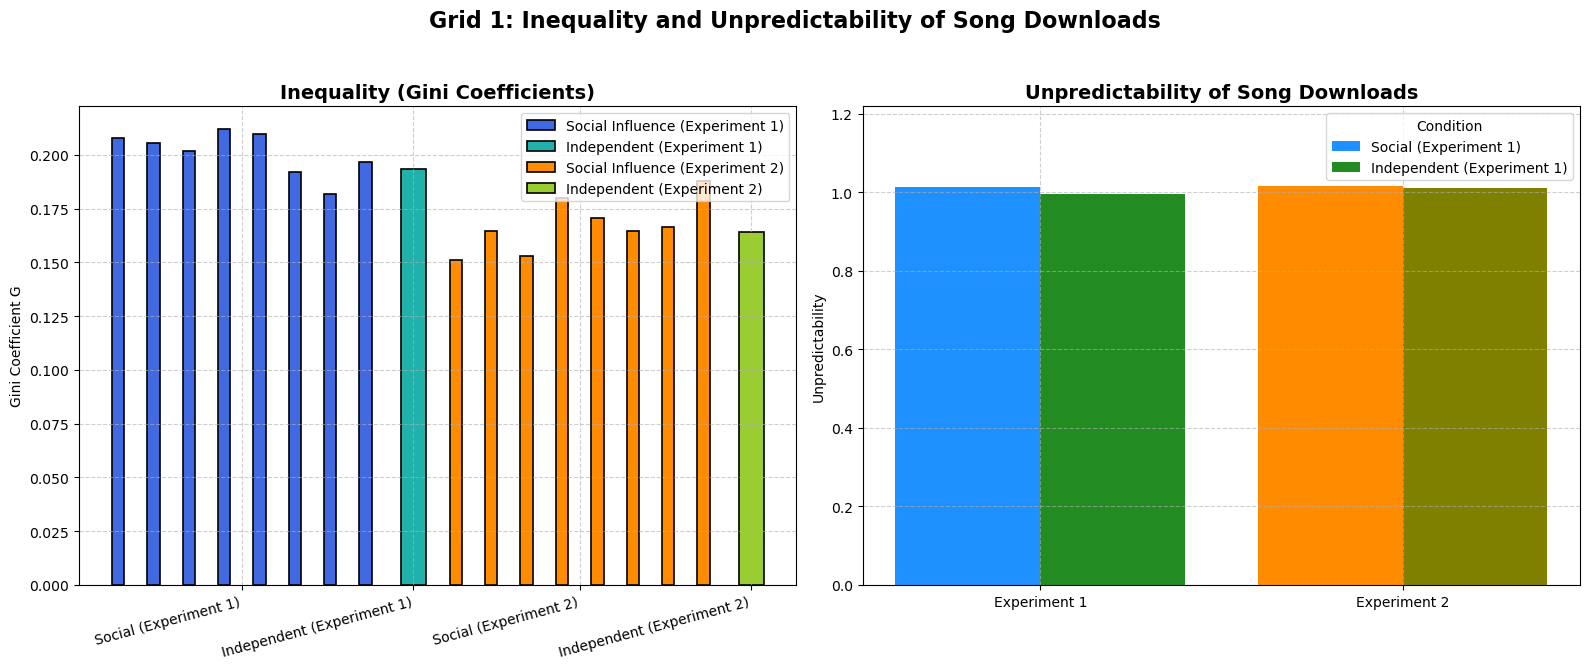

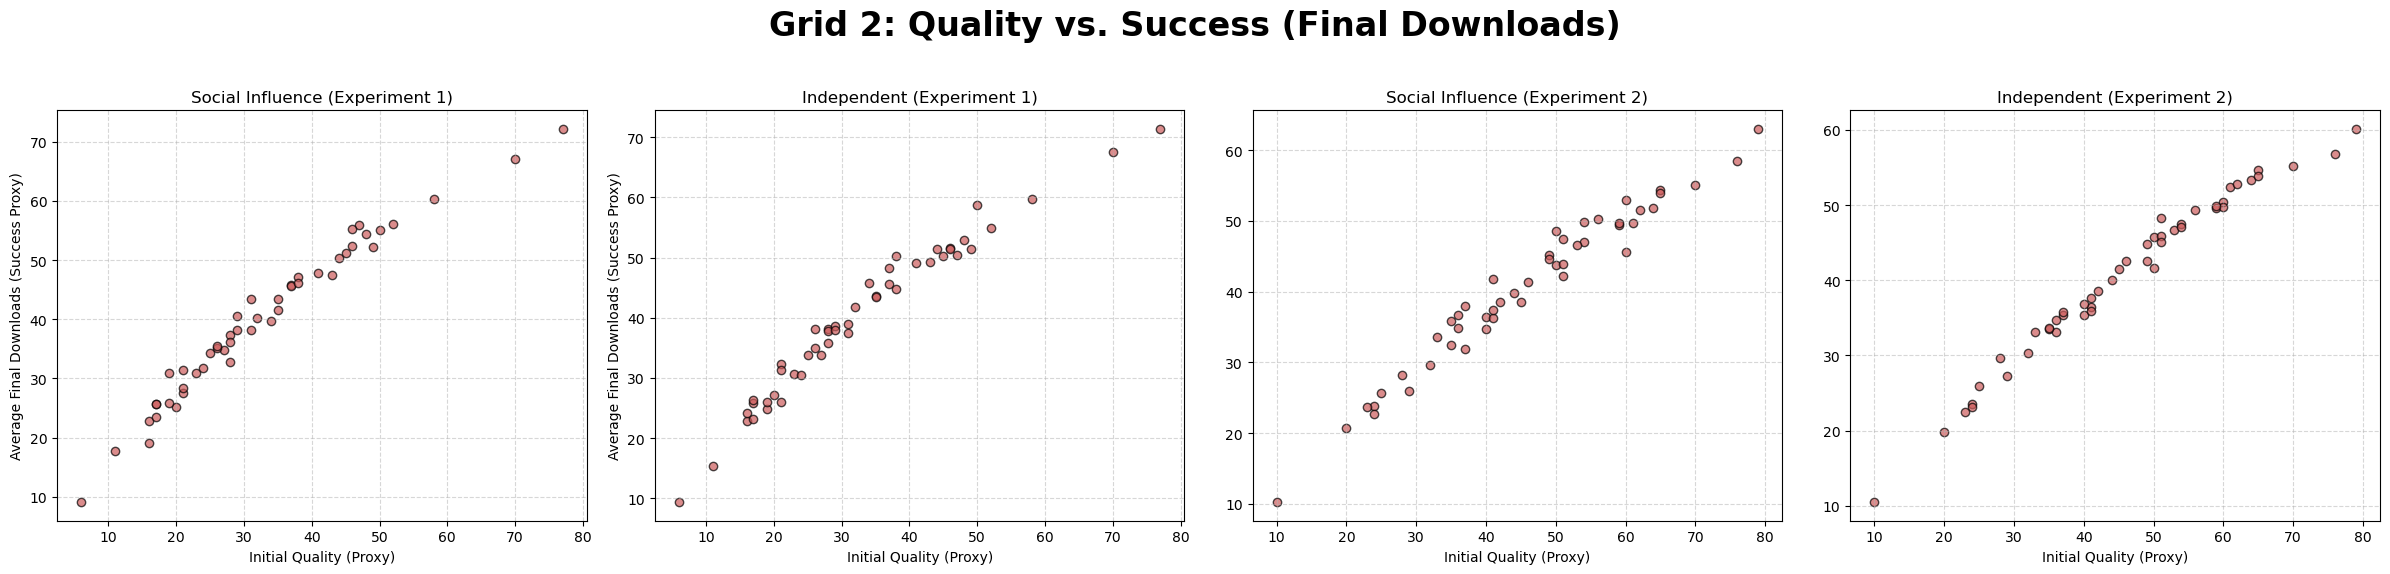

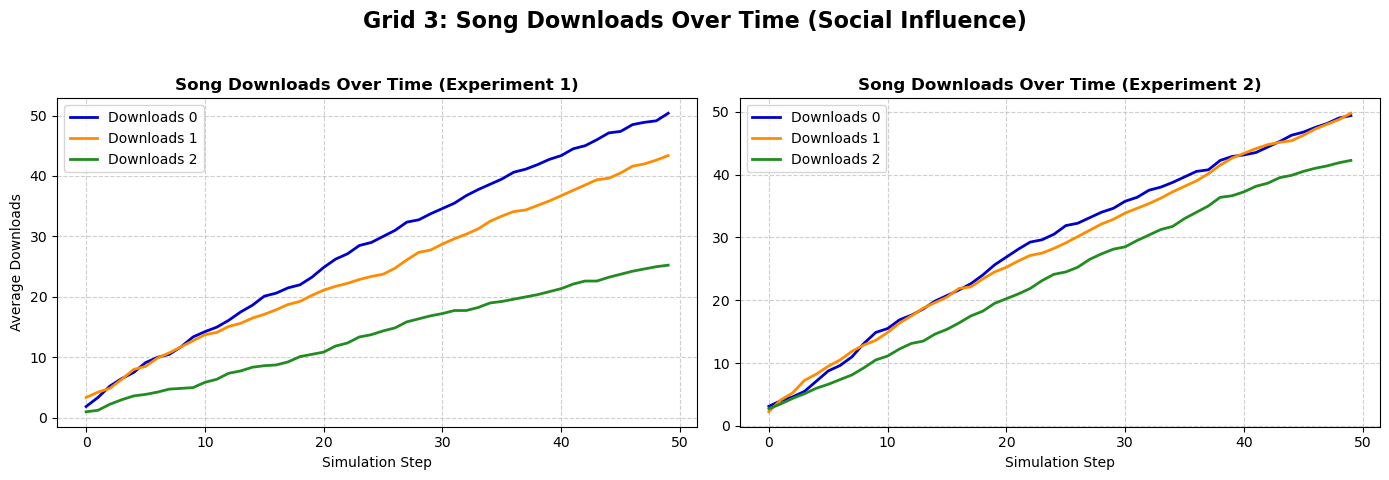

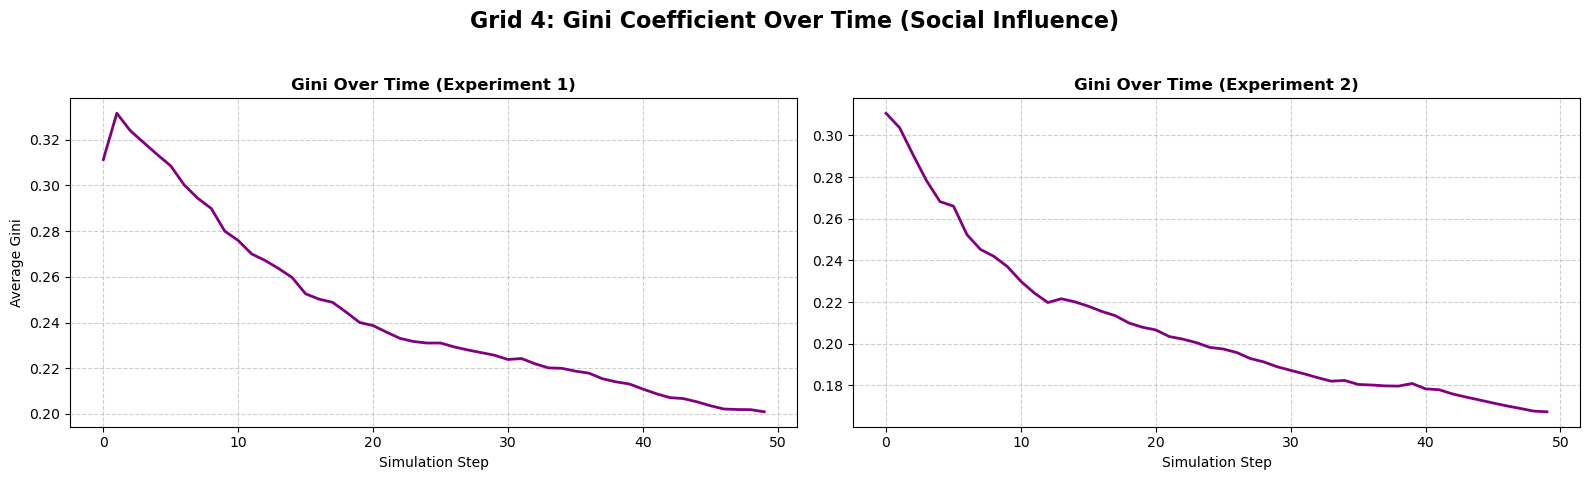

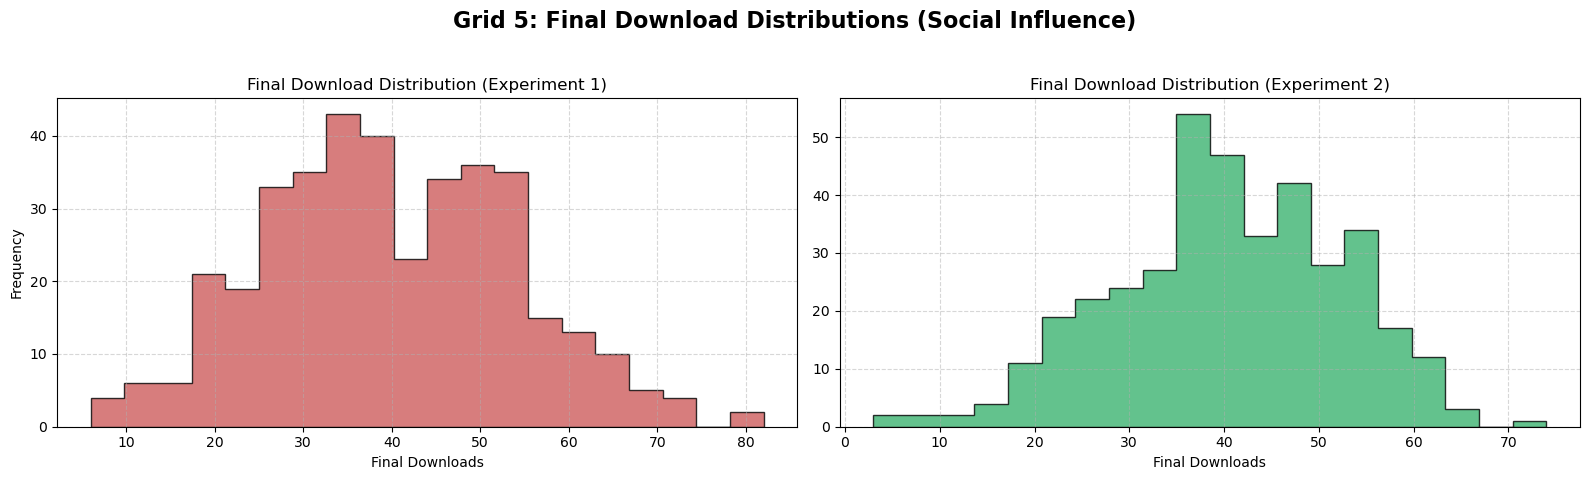

In [54]:
def run_and_collect_experiment_data(exp_name, initial_quality_filepath, quality_col_idx, 
                                    num_listeners, sim_steps, influence_factor, 
                                    choice_prob, num_sims):
    """Loads data, runs simulations, and returns results for one experiment without plotting."""
    print(f"\n--- Running ABM for {exp_name} ---")
    initial_quality_map = load_initial_quality_abm(initial_quality_filepath, quality_col_idx)
    if not initial_quality_map:
        print(f"Could not load initial quality for {exp_name}. Skipping.")
        return None

    (social_gini_vals, social_final_down, social_avg_song_down_time, 
     social_avg_gini_time, social_init_qual_list) = run_abm_simulation_set(
        initial_quality_map, num_listeners, sim_steps, influence_factor, choice_prob, num_sims)
    print(f"  Social Influence - Avg Final Gini: {np.mean(social_gini_vals):.4f}")

    (indep_gini_vals, indep_final_down, _, 
     _, indep_init_qual_list) = run_abm_simulation_set( 
        initial_quality_map, num_listeners, sim_steps, 0, choice_prob, num_sims) 
    avg_indep_gini = np.mean(indep_gini_vals)
    print(f"  Independent - Avg Final Gini: {avg_indep_gini:.4f}")

    unpredictability_social = calculate_unpredictability_abm(social_final_down)
    unpredictability_independent = calculate_unpredictability_abm(indep_final_down)  
    print(f"  Social Unpredictability: {unpredictability_social:.4f}")
    print(f"  Independent Unpredictability: {unpredictability_independent:.4f}")

    experiment_results = {
        "name": exp_name,
        "social_gini_raw": social_gini_vals, 
        "independent_gini_avg": avg_indep_gini,
        "unpredictability": [unpredictability_social, unpredictability_independent],
        "quality_vs_success": {
            "social_downloads": social_final_down, "social_quality": social_init_qual_list,
            "independent_downloads": indep_final_down, "independent_quality": indep_init_qual_list
        },
        "time_series": {
            "social_song_downloads": social_avg_song_down_time,
            "social_gini": social_avg_gini_time
        },
        "distributions": {
            "social_final_downloads": social_final_down
        }
    }
    return experiment_results

if __name__ == "__main__":
    all_experiments_data = [] 

    exp1_data = run_and_collect_experiment_data(
        "Experiment 1", 
        os.path.join(DATA_DIR, "downloads_v1_lexorder.txt"), 9,
        NUM_LISTENERS, SIMULATION_STEPS, INFLUENCE_FACTOR, 
        INITIAL_CHOICE_PROBABILITY, NUM_SIMULATIONS
    )
    if exp1_data: 
        all_experiments_data.append(exp1_data)

    exp2_data = run_and_collect_experiment_data(
        "Experiment 2", 
        os.path.join(DATA_DIR, "downloads_v2_lexorder.txt"), 9,
        NUM_LISTENERS, SIMULATION_STEPS, INFLUENCE_FACTOR, 
        INITIAL_CHOICE_PROBABILITY, NUM_SIMULATIONS
    )
    if exp2_data: 
        all_experiments_data.append(exp2_data)

    if not all_experiments_data:
        print("No experiment data processed. Check file paths and configurations.")
        exit()

    # Grid Layout 1: Inequality of Song Downloads (Gini Coefficients and Unpredictability)
    fig_inequality, axes_inequality = plt.subplots(1, 2, figsize=(16, 7))
    
   
    gini_plot_data = {exp['name']: {"social": exp['social_gini_raw'], "independent": exp['independent_gini_avg']} 
                      for exp in all_experiments_data}
    plot_gini_coefficients_abm(gini_plot_data, axes_inequality[0])
    axes_inequality[0].set_title("Inequality (Gini Coefficients)", fontsize=14, fontweight='bold')

    
    unpred_plot_data = {exp['name']: exp['unpredictability'] for exp in all_experiments_data}
    
    x_pos = np.arange(len(all_experiments_data)) 
    width = 0.4

    colors_social = ['dodgerblue', 'darkorange']
    colors_independent = ['forestgreen', 'olive']

    for i, exp in enumerate(all_experiments_data):
        social_val, indep_val = exp['unpredictability']
        axes_inequality[1].bar(x_pos[i] - width/2, social_val, width, label=f'Social ({exp["name"]})' if i == 0 else "", color=colors_social[i])
        axes_inequality[1].bar(x_pos[i] + width/2, indep_val, width, label=f'Independent ({exp["name"]})' if i == 0 else "", color=colors_independent[i])

    axes_inequality[1].set_ylabel('Unpredictability')
    axes_inequality[1].set_title('Unpredictability of Song Downloads', fontsize=14, fontweight='bold')
    axes_inequality[1].set_xticks(x_pos)
    axes_inequality[1].set_xticklabels([exp['name'] for exp in all_experiments_data])
    axes_inequality[1].set_ylim(0, max(0.015, max(val for exp in all_experiments_data for val in exp['unpredictability']) * 1.2))
    axes_inequality[1].legend(title="Condition")
    axes_inequality[1].grid(True, linestyle='--', alpha=0.6)


    fig_inequality.suptitle("Grid 1: Inequality and Unpredictability of Song Downloads", fontsize=16, fontweight='bold')
    fig_inequality.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(FIGURE_OUTPUT_DIR, "grid_1_inequality_unpredictability.png"))
    plt.show()

    # Grid Layout 2: Quality vs. Success
    
    num_exp = len(all_experiments_data)
    fig_quality_success, axes_quality_success = plt.subplots(1, num_exp * 2, figsize=(6 * num_exp * 2, 6))
    
    
    if num_exp == 1: 
        axes_quality_success = [axes_quality_success[0], axes_quality_success[1]] 
    else:
        axes_quality_success = axes_quality_success.flatten() 

    for i, exp in enumerate(all_experiments_data):
        social_ax = axes_quality_success[i*2]
        indep_ax = axes_quality_success[i*2 + 1]
        
        plot_quality_vs_success_abm(exp['quality_vs_success']['social_downloads'], 
                                    exp['quality_vs_success']['social_quality'],
                                    exp['quality_vs_success']['independent_downloads'], 
                                    exp['quality_vs_success']['independent_quality'],
                                    exp['name'], social_ax, indep_ax)
        
        if i > 0:
            social_ax.set_ylabel("")
            indep_ax.set_ylabel("")

    fig_quality_success.suptitle("Grid 2: Quality vs. Success (Final Downloads)", fontsize=24, fontweight='bold')
    fig_quality_success.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(FIGURE_OUTPUT_DIR, "grid_2_quality_vs_success.png"))
    plt.show()

    # Grid Layout 3: Song Downloads Over Time 
    
    songs_to_plot_count = 3 
    fig_downloads_time, axes_downloads_time = plt.subplots(1, num_exp, figsize=(7 * num_exp, 5))
    if num_exp == 1: axes_downloads_time = [axes_downloads_time] 

    for i, exp in enumerate(all_experiments_data):
        current_ax = axes_downloads_time[i]
        
        quality_file = os.path.join(DATA_DIR, f"downloads_v{i+1}_lexorder.txt")
        initial_quality_map_for_exp = load_initial_quality_abm(quality_file, 9)
        
        
        songs_to_plot = list(initial_quality_map_for_exp.keys())[:songs_to_plot_count]
        
        avg_downloads_to_plot = {k: exp['time_series']['social_song_downloads'][k] 
                                 for k in songs_to_plot if k in exp['time_series']['social_song_downloads']}
        
        plot_time_series(avg_downloads_to_plot, "Downloads", 
                         f'Song Downloads Over Time ({exp["name"]})', 
                         current_ax)
        if i > 0: current_ax.set_ylabel("") 

    fig_downloads_time.suptitle("Grid 3: Song Downloads Over Time (Social Influence)", fontsize=16, fontweight='bold')
    fig_downloads_time.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(FIGURE_OUTPUT_DIR, "grid_3_song_downloads_time.png"))
    plt.show()

    # Grid Layout 4: Gini Coefficient Over Time 
    fig_gini, axes_gini = plt.subplots(1, num_exp, figsize=(8 * num_exp, 5))  
    if num_exp == 1: axes_gini = [axes_gini]  

    for i, exp in enumerate(all_experiments_data):
        current_ax = axes_gini[i]
        plot_time_series(exp['time_series']['social_gini'], "Gini", 
                         f'Gini Over Time ({exp["name"]})', 
                         current_ax)
        if i > 0: current_ax.set_ylabel("")  

    fig_gini.suptitle("Grid 4: Gini Coefficient Over Time (Social Influence)", fontsize=16, fontweight='bold')
    fig_gini.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(FIGURE_OUTPUT_DIR, "grid_4_gini_time.png"))
    plt.show()

    # Grid Layout 5: Final Download Distributions 
    fig_dist, axes_dist = plt.subplots(1, num_exp, figsize=(8 * num_exp, 5))  
    if num_exp == 1: axes_dist = [axes_dist]  

    for i, exp in enumerate(all_experiments_data):
        current_ax = axes_dist[i]
        plot_final_distribution(exp['distributions']['social_final_downloads'], 
                                f'Final Download Distribution ({exp["name"]})',
                                current_ax,
                                color='indianred' if '1' in exp['name'] else 'mediumseagreen')
        if i > 0: current_ax.set_ylabel("")  

    fig_dist.suptitle("Grid 5: Final Download Distributions (Social Influence)", fontsize=16, fontweight='bold')
    fig_dist.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(FIGURE_OUTPUT_DIR, "grid_5_final_download_distributions.png"))
    plt.show()

## Connecting Our Model to the Research Paper

This agent-based simulation closely replicates the experimental setup and core findings of Salganik, Dodds, and Watts (2006), “Experimental Study of Inequality and Unpredictability in an Artificial Cultural Market.” The original study explored how social influence shapes success in cultural markets through a web-based music platform. Participants were either shown or not shown the number of times each song had been downloaded. This created two conditions: independent and social influence. Participants in the social influence group were further divided into eight parallel “worlds,” which evolved independently despite identical starting conditions.

Our model reproduces this design using agent-based simulations, with agents making song download decisions based on both intrinsic preference and popularity (i.e., social influence). 

**Key measures from the original study—inequality and unpredictability—are implemented directly in the model:**

**The Gini coefficient**, used in the paper to quantify inequality of success **(Figure 1)**, is calculated using calculate_gini() and visualized through plot_gini_coefficients_abm().

**Unpredictability**, defined as the variation in a song’s success across different worlds **(Figure 2)**, is captured by calculate_unpredictability_abm() and visualized through plot_unpredictability_abm_reproduction().

To analyze the relationship between initial **quality and final success (Figure 3)**, the model uses **plot_quality_vs_success_abm()**. This reproduces the paper’s finding that while quality and success are weakly correlated, high variability persists, and quality alone is not predictive of outcome.

The agent-based architecture (through Listener and MusicDownloadModel) allows for simulating the micro-macro dynamics central to the paper: 
**how individual behavior, shaped by social cues, can lead to emergent market-level patterns of inequality and unpredictability.**

Therefore, our model serves as a computational realization of the Salganik et al. experiment. It also helps reinforce the paper’s key insight: **success in cultural markets is not solely driven by quality, but also by social context and chance.**



## Conclusion 

This simulation confirmed that social influence amplifies inequality and unpredictability in cultural markets, as shown by Salganik et al. (2006). Even with identical starting conditions, different outcomes emerged, proving that success is often not based on quality alone. Popularity can snowball from small early differences, and high-quality songs don’t always win. The agent-based model effectively demonstrated how simple individual behaviors lead to complex group dynamics, helping us understand why predicting cultural success is so difficult.

